# Trapping SINDy
By Alan Kaptanoglu and Jared Callaham

This example illustrates the use of the new SINDy extension on a number of canonical fluid systems. The algorithm searches for stable systems with energy-preserving quadratic nonlinearities. This builds off of the new constrained SINDy algorithm based on SR3. The trapping theorem for stability utilized in this SINDy algorithm can be found in Schlegel, M., & Noack, B. R. (2015). On long-term boundedness of Galerkin models. Journal of Fluid Mechanics, 765, 325-352. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec

In [2]:
def make_constraints(r):
    q = 0
    Nr = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * Nr))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (Nr - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (Nr - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (Nr - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix
    
    
def make_Ptensor(r):
    Nr = int((r ** 2 + 3 * r) / 2.0)

    # delta_{il}delta_{jk}
    PL_tensor = np.zeros((r, r, r, Nr))
    for i in range(r):
        for j in range(r):
            for k in range(r):
                for l in range(Nr):
                    if i == l and j == k:
                        PL_tensor[i, j, k, l] = 1.0

    # Now symmetrize PL
    for i in range(r):
        for j in range(Nr):
            PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)

    PQ_tensor = np.zeros((r, r, Nr))
    for i in range(r):
        # Off diagonal terms
        for j in range(i+1, r):
            PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0  # opt_m[k]  

        # diagonal terms
        PQ_tensor[i, i, Nr - r + i] = 1.0  # opt_m[j]

    # Now symmetrize PQ
    for j in range(Nr):
        PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)
        
    return PL_tensor, PQ_tensor


# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, sindy_opt):
    Nr = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor = sindy_opt.PL
    PQ_tensor = sindy_opt.PQ
    mPQ = np.zeros(PL_tensor.shape)
    for i in range(r):
        for j in range(i + 1, r):
            mPQ[i, j, :, int((i + 1) / 2.0 * (2 * r - i)) + j - 1 - i] = opt_m
    for i in range(r):
        mPQ[i, i, :, Nr - r + i] = opt_m
    for i in range(r):
        for j in range(Nr):
            mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    smallest_eigval = np.sort(eigvals)[0]
    largest_eigval = np.sort(eigvals)[-1]
    L = np.tensordot(PL_tensor, Xi, axes=([3,2],[0,1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([2],[0]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2],[0])), opt_m)
    Rm = np.sqrt(smallest_eigval/largest_eigval)*np.linalg.norm(d)
    print('d = ', d)
    print('Rm = ', Rm)


def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(8, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')

    
def make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, filename):
    fig = plt.figure(figsize=(8, 8))
    spec = gridspec.GridSpec(ncols=r, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(0, r):
        for j in range(i, r):
            plt.subplot(spec[i, j])
            plt.plot(x_train[:, i], x_train[:, j],linewidth=1)
            plt.plot(x_train_pred[:, i], x_train_pred[:, j], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        for j in range(0, i):
            plt.subplot(spec[i, j])
            plt.plot(x_test[:, j], x_test[:, i], 'r', linewidth=1)
            plt.plot(x_test_pred[:, j], x_test_pred[:, i], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])     
    plt.savefig(filename + '_lissajou.pdf')



library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5

In [3]:
# Define the derivatives for each of the examples
def meanfield_deriv(x_y_z, t0, mu):
    x, y, z = x_y_z
    return [mu * x - y - x * z, 
            mu * y + x - y * z, 
            - z + x ** 2 + y ** 2]


def oscillator_deriv(x_y_z, t0, mu1, mu2, omega, alpha, beta, sigma):
    x, y, z = x_y_z
    return [mu1 * x + sigma * x * y, 
            mu2 * y + (omega + alpha * y + beta * z) * z - sigma * x ** 2, 
            mu2 * z - (omega + alpha * y + beta * z) * y]


def lorenz_deriv(x_y_z, t0, sigma, beta, rho):
    x, y, z = x_y_z
    return [sigma * (y - x), 
            x * (rho - z) - y, 
            x * y - beta * z]


def mhd_deriv(x_y_z_u_v_w, t0, nu=0.0, mu=0.0, sigma=0.0):
    x, y, z, u, v, w = x_y_z_u_v_w
    return [-2*nu*x + 4.0*(y*z - v*w), -5*nu*y - 7.0*(x*z - u*w), 
            -9*nu*z + 3.0*(x*y - u*v), -2*mu*u + 2.0*(w*y - z*v), 
            -5*mu*v + sigma*w + 5.0*(z*u - x*w), -9*mu*w + sigma*v + 9.0*(v*x - y*u)]

# Simple mean field model

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.83375e-09  4.10668e-05  0.00000e+00
          50  1.64854e-09  5.90897e-06  0.00000e+00
         100  1.87142e-09  1.03401e-06  0.00000e+00
         150  2.01593e-09  2.72348e-07  0.00000e+00
         200  2.08893e-09  1.21068e-07  0.00000e+00
         250  2.14096e-09  7.41329e-08  0.00000e+00
         300  2.18419e-09  4.83889e-08  0.00000e+00
         350  2.21768e-09  3.31372e-08  0.00000e+00
         400  2.24401e-09  2.36389e-08  0.00000e+00
         450  2.26504e-09  1.74579e-08  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:423: ConvergenceWarning: trappingSR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


x0' = 0.001 x0 + -1.000 x1 + -1.000 x0x2
x1' = 1.000 x0 + 0.001 x1 + -1.000 x1x2
x2' = -1.000 x2 + 1.000 x0x0 + 1.000 x1x1
optimal m:  [-0.15617146 -0.07493979  1.09503041]
As eigvals:  [-1.14552766 -1.09400296 -0.94846737]
d =  [-0.08566275 -0.0411688  -1.11001567]
Rm =  1.224353519064013


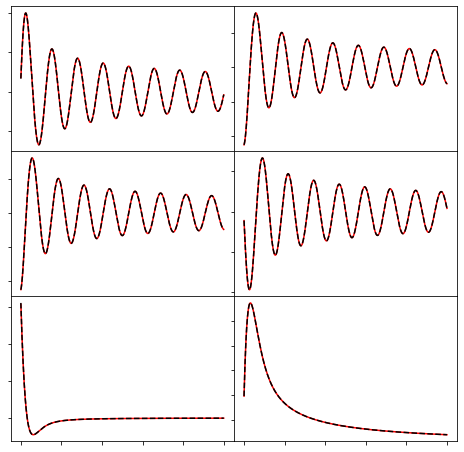

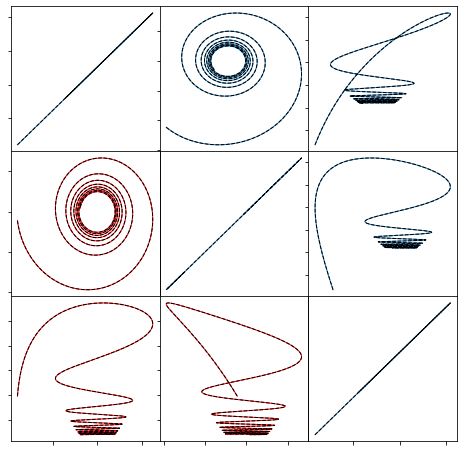

In [4]:
r = 3
mu = 1e-3
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)

x0 = (np.random.rand(3) - 0.5)
x_train = integrate.odeint(meanfield_deriv, x0, t, (mu,), rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x0 = (np.random.rand(3) - 0.5)
x_test = integrate.odeint(meanfield_deriv, x0, t, (mu,), rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# run trapping SINDy
threshold = 0.0
eta = 1e5
alpha_m = 1e-2 * eta
alpha_A = 1.0 * eta
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, PL=PL_tensor, PQ=PQ_tensor, max_iter=500, tol=1e-20, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0,:], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0,:], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')

# Simple atmospheric model

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.13652e-03  8.70610e-06  0.00000e+00
         250  1.13652e-03  4.99733e-07  0.00000e+00
         500  1.13652e-03  4.90510e-07  0.00000e+00
         750  1.13652e-03  4.90029e-07  0.00000e+00
        1000  1.13652e-03  4.89998e-07  0.00000e+00
        1250  1.13652e-03  4.89996e-07  0.00000e+00
        1500  1.13652e-03  4.89996e-07  0.00000e+00
        1750  1.13652e-03  4.89996e-07  0.00000e+00
        2000  1.13652e-03  4.89996e-07  0.00000e+00
        2250  1.13652e-03  4.89996e-07  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:423: ConvergenceWarning: trappingSR3._reduce did not converge after 2500 iterations.
  ConvergenceWarning,


x0' = 0.050 x0 + 1.100 x0x1
x1' = -0.010 x1 + 2.999 x2 + 0.001 x0x2 + -1.999 x1x2 + -1.100 x0x0 + -4.998 x2x2
x2' = -2.999 x1 + -0.010 x2 + -0.001 x0x1 + 4.998 x1x2 + 1.999 x1x1
optimal m:  [-1.58416294e-04 -9.54707703e-01  3.81745023e-01]
As eigvals:  [-5.54462384 -1.         -0.01005474]
d =  [-1.86894205e-06  9.59934622e-03 -3.83833775e-03]
Rm =  0.24277250976916165


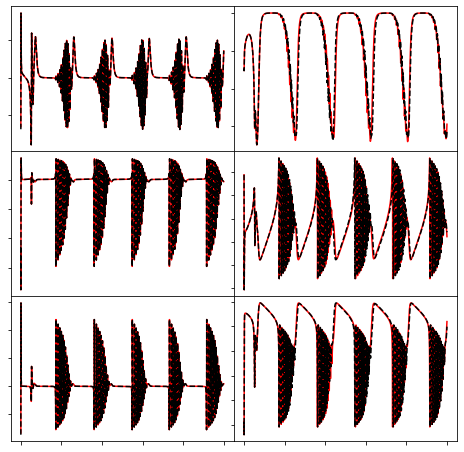

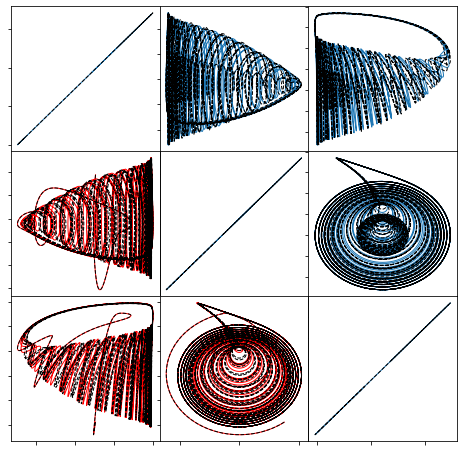

In [6]:
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps*k1
mu2 = -eps*k2
alpha = -2.0
omega = 3.0
dt = 0.01
T = 500
t = np.arange(0,T+dt,dt)

x0 = (np.random.rand(3) - 0.5)
x_train = integrate.odeint(oscillator_deriv, x0, t, (mu1, mu2, omega, alpha, beta, sigma), 
                           rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x0 = (np.random.rand(3) - 0.5)
x_test = integrate.odeint(oscillator_deriv, x0, t, (mu1, mu2, omega, alpha, beta, sigma),
                          rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# run trapping SINDy
eta = 1.0e6
alpha_m = 1.0e-2 * eta
alpha_A = 1.0 * eta
threshold = 0.0
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, mtol=1e-10,
                          PL=PL_tensor, PQ=PQ_tensor, max_iter=2500, tol=1e-20,
                          gamma=-1,
                          constraint_lhs=constraint_matrix,
                          constraint_rhs=constraint_zeros,
                          constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0,:], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0,:], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')

# Lorenz model

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.78799e+03  1.19335e+04  0.00000e+00
          50  1.10274e+03  2.51691e+01  0.00000e+00
         100  1.13021e+03  4.74656e+00  0.00000e+00
         150  1.11767e+03  1.94718e+00  0.00000e+00
         200  1.10056e+03  1.07620e+00  0.00000e+00
         250  1.08370e+03  6.95630e-01  0.00000e+00
         300  1.06794e+03  4.95030e-01  0.00000e+00
         350  1.05336e+03  3.75905e-01  0.00000e+00
         400  1.03986e+03  2.99083e-01  0.00000e+00
         450  1.02729e+03  2.46460e-01  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:423: ConvergenceWarning: trappingSR3._reduce did not converge after 500 iterations.
  ConvergenceWarning,


x0' = -9.650 x0 + 9.891 x1 + -0.059 x2 + -0.023 x0x1 + -0.007 x0x2 + 0.017 x1x1 + 0.002 x2x2
x1' = 27.040 x0 + -0.494 x1 + 0.090 x2 + -0.017 x0x1 + -0.974 x0x2 + -0.013 x1x2 + 0.023 x0x0 + -0.003 x2x2
x2' = 0.074 x0 + -0.086 x1 + -2.660 x2 + 0.974 x0x1 + -0.002 x0x2 + 0.003 x1x2 + 0.007 x0x0 + 0.013 x1x1
optimal m:  [1.73719649e-01 3.85061493e-03 3.69930949e+01]
As eigvals:  [-9.94234333 -2.661479   -0.93539907]
d =  [ -2.76448229   8.76178086 -98.37607788]
Rm =  322.1225903932674


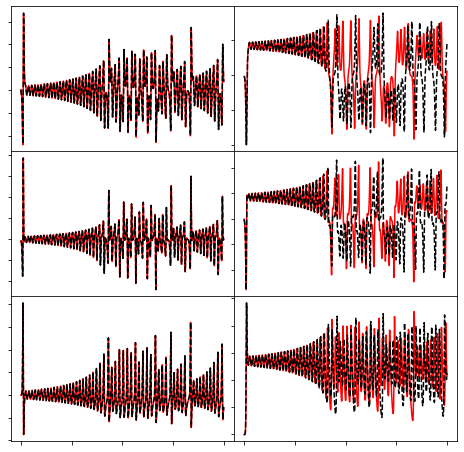

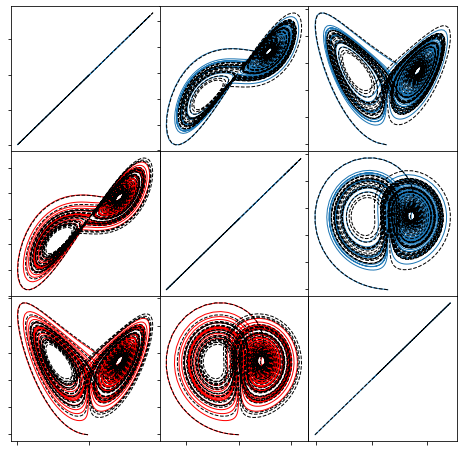

In [7]:
r = 3
sigma = 10.0
beta = 8.0/3.0
rho = 28.0

dt = 0.01
T = 40
t = np.arange(0,T+dt,dt)

x0 = (np.random.rand(3) - 0.5)
x_train = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho), 
                           rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x0 = (np.random.rand(3) - 0.5)
x_test = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho), 
                          rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# run trapping SINDy
eta = 1.0e-2
alpha_m = 0.5 * eta
alpha_A = 1.0 * eta
threshold = 0.0
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, mtol=1e-10,
                          PL=PL_tensor, PQ=PQ_tensor, max_iter=500, tol=1e-20,
                          gamma=-1,
                          constraint_lhs=constraint_matrix,
                          constraint_rhs=constraint_zeros,
                          constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0,:], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0,:], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'lorenz')

In [ ]:
# Run comparison between unconstrained, constrained, and trapping algorithms on noisy Lorenz data
# Note this takes a LONG time because CVXPY is slow
if False:
    fig1,ax1 = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(8,8))
    fig2,ax2 = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(8,8))
    fig3,ax3 = plt.subplots(2,2,subplot_kw={'projection': '3d'},figsize=(8,8))

    threshold = 0.001
    x0 = [1, -1, 20]
    variances = np.ones(4) * 3.0
    x_orig = integrate.odeint(lorenz_deriv, x0, t, (sigma, beta, rho), 
                              rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
    x0_pred = (np.random.rand(2,2,3)-0.5)*20
    for ii in range(2):
        for jj in range(2):
            noise = np.random.normal(0.0, variances[ii * 2 + jj], x_train.shape)
            x_train = x_orig + noise
            x_test = integrate.odeint(lorenz_deriv, x0_pred[ii, jj], t, (sigma, beta, rho), 
                                      rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

            # unconstrained SINDy
            sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, 
                                          max_iter=2000, tol=1e-10, thresholder="l1")

            model = ps.SINDy(
                optimizer=sindy_opt,
                feature_library=sindy_library,
                differentiation_method=ps.FiniteDifference(drop_endpoints=True),
            )
            model.fit(x_train, t=t)
            ax1[ii,jj].plot(x_test[:,0], x_test[:,1], x_test[:,2],linewidth=2)
            x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
            if not np.any(np.abs(x_test_pred) > 100):
                ax1[ii,jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'r--', linewidth=2)

            # constrained SINDy
            sindy_opt = ps.ConstrainedSR3(threshold=threshold, nu=1.0, max_iter=2000, tol=1e-10,
                                          thresholder="l1",
                                          constraint_lhs=constraint_matrix,
                                          constraint_rhs=constraint_zeros,
                                          constraint_order="feature")
            model = ps.SINDy(
                optimizer=sindy_opt,
                feature_library=sindy_library,
                differentiation_method=ps.FiniteDifference(drop_endpoints=True),
            )
            model.fit(x_train, t=t)
            ax2[ii,jj].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], linewidth=2)
            x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
            if not np.any(np.abs(x_test_pred) > 100):
                ax2[ii,jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'm--', linewidth=2)

            eta = 1.0e-3
            alpha_m = 2e-1 * eta
            alpha_A = 1.0 * eta
            if threshold == 0.0:
                max_iter = 5000
            else:
                max_iter = 1000  # 1200

            # trapping SINDy -- initial guess for m because otherwise this takes a long time
            sindy_opt = ps.trappingSR3(threshold=threshold, alpha_m=alpha_m, alpha_A=alpha_A, eta=eta, 
                                       mtol=1e-8, accel=False,
                                       PL=PL_tensor, PQ=PQ_tensor, max_iter=max_iter, tol=1e-15,
                                       m0=[0, 0, 31], gamma=-0.1,
                                       constraint_lhs=constraint_matrix,
                                       constraint_rhs=constraint_zeros,
                                       constraint_order="feature")
            model = ps.SINDy(
                optimizer=sindy_opt,
                feature_library=sindy_library,
                differentiation_method=ps.FiniteDifference(drop_endpoints=True),
            )
            model.fit(x_train, t=t)
            Xi = model.coefficients().T
            check_stability(r, Xi, sindy_opt)
            ax3[ii, jj].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], linewidth=2)
            x_test_pred = model.simulate(x0_pred[ii, jj], t, integrator_kws=integrator_keywords)
            ax3[ii,jj].plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k--', linewidth=2)
            ax1[ii,jj].set_xticklabels([])
            ax1[ii,jj].set_yticklabels([])
            ax1[ii,jj].set_zticklabels([])     
            ax1[ii,jj].dist = 8
            ax1[ii,jj].set_axis_off()
            ax2[ii,jj].set_xticklabels([])
            ax2[ii,jj].set_yticklabels([])
            ax2[ii,jj].set_zticklabels([])     
            ax2[ii,jj].dist = 8
            ax2[ii,jj].set_axis_off()
            ax3[ii,jj].set_xticklabels([])
            ax3[ii,jj].set_yticklabels([])
            ax3[ii,jj].set_zticklabels([])     
            ax3[ii,jj].dist = 8
            ax3[ii,jj].set_axis_off()


# MHD model

 Iteration | Data Error | Stability Error |   L1 Error
           0  3.67130e-04  3.82087e-01  0.00000e+00
        2000  2.13320e-05  3.00014e-02  0.00000e+00
        4000  2.03425e-05  3.00011e-02  0.00000e+00
        6000  2.09517e-05  3.00024e-02  0.00000e+00
        8000  2.01353e-05  3.00018e-02  0.00000e+00
       10000  1.98440e-05  3.00017e-02  0.00000e+00
       12000  1.98440e-05  3.00017e-02  0.00000e+00
       14000  1.98440e-05  3.00017e-02  0.00000e+00
       16000  1.98440e-05  3.00017e-02  0.00000e+00
       18000  1.98440e-05  3.00017e-02  0.00000e+00


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/trapping_sr3.py:423: ConvergenceWarning: trappingSR3._reduce did not converge after 20000 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in sqrt


x0' = 4.000 x1x2 + -4.000 x4x5
x1' = -7.000 x0x2 + 7.000 x3x5
x2' = 3.000 x0x1 + -3.000 x3x4
x3' = 2.000 x1x5 + -2.000 x2x4
x4' = -5.000 x0x5 + 5.000 x2x3
x5' = 9.000 x0x4 + -9.000 x1x3
optimal m:  [-3.08758197e-06  4.95137418e-07  9.48969186e-06  4.17727579e-07
  5.28167180e-08 -5.24969193e-06]
As eigvals:  [-1.00187911e-04 -4.39624773e-05 -1.20188033e-05  2.53719975e-06
  9.93569013e-05  2.25802821e-04]
d =  [-6.18543759e-11  2.57261528e-10  8.16093294e-10  3.50174106e-11
 -2.41527686e-10 -6.76032885e-10]
Rm =  nan


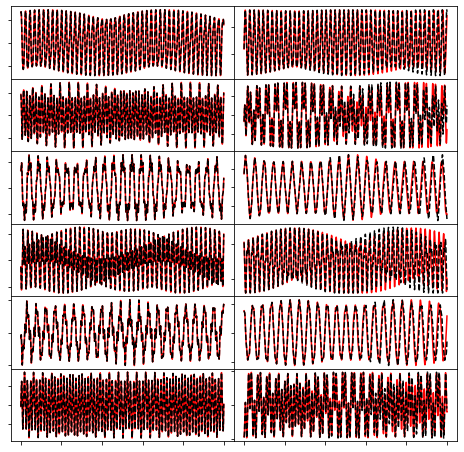

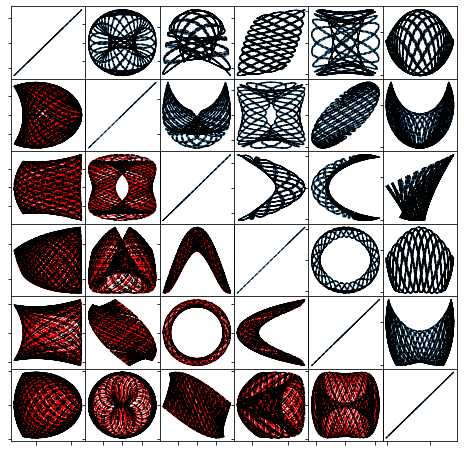

In [8]:
r = 6
nu = 0.0
mu = 0.0

dt = 0.001
T = 100
t = np.arange(0,T+dt,dt)

x0 = (np.random.rand(6) - 0.5)
x_train = integrate.odeint(mhd_deriv, x0, t,
                           rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x0 = (np.random.rand(6) - 0.5)
x_test = integrate.odeint(mhd_deriv, x0, t,
                          rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

# run trapping SINDy
eta = 1.0e2
alpha_m = 5.0e-3 * eta
alpha_A = 1.0 * eta
threshold = 0.0
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, mtol=1e-10,
                          PL=PL_tensor, PQ=PQ_tensor, max_iter=20000, tol=1e-20,
                          gamma=-1,
                          constraint_lhs=constraint_matrix,
                          constraint_rhs=constraint_zeros,
                          constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0,:], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0,:], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'mhd')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'mhd')

# Forced Burger's Equation

In [ ]:
# Rather than defining an ODE, we just read in some DNS data
import scipy.io as sio
tstart = 0
tend = 1000
Burgers = sio.loadmat('data/burgers.mat')
skip = 2
nu = Burgers['nu'].item()
sigma = Burgers['sigma'].item()
U = Burgers['U'].item()
t = (Burgers['t'].flatten())[tstart:tend:skip]
x_train = Burgers['a']
u_train = Burgers['u'][:, tstart:tend:skip]
theta = Burgers['x'].flatten()
spatial_modes_train = Burgers['theta']
print(U, nu, sigma)
del Burgers
r = 8
x_train = x_train[:r, tstart:tend:skip].T

Burgers = sio.loadmat('data/burgers2.mat')
x_test = Burgers['a']
u_test = Burgers['u'][:, tstart:tend:skip]
spatial_modes_test = Burgers['theta']
del Burgers
x_test = x_test[:r, tstart:tend:skip].T

# run trapping SINDy
eta = 1e5
threshold = 0.0
alpha_m = 1e-7 * eta
alpha_A = 1.0 * eta
PL_tensor, PQ_tensor = make_Ptensor(r)
constraint_zeros, constraint_matrix = make_constraints(r)
sindy_opt = ps.trappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, accel=False, 
                           mtol=1e-10, PL=PL_tensor, PQ=PQ_tensor, max_iter=5000, tol=1e-20, gamma=-0.1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
check_stability(r, Xi, sindy_opt)
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0,:], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0,:], t, integrator_kws=integrator_keywords)
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'burgers')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'burgers')

1.0 0.025 0.1
 Iteration | Data Error | Stability Error |   L1 Error
           0  4.43325e-07  4.47117e-04  0.00000e+00
         500  2.54264e-05  1.30714e-02  0.00000e+00


In [ ]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
plt.pcolor(t, theta, u_train, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon = np.dot(spatial_modes_train[:r, :].T, x_train.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 3)
plt.pcolormesh(t, theta, recon, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon = np.dot(spatial_modes_train[:r, :].T, x_train_pred.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 5)
plt.pcolormesh(t, theta, recon, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
plt.xlim(0, 200)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
cb.ax.tick_params(labelsize=30)
#
plt.subplot(3, 2, 2)
plt.pcolor(t, theta, u_test, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon = np.dot(spatial_modes_test[:r, :].T, x_test.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 4)
plt.pcolormesh(t, theta, recon, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=30)
plt.xlim(0, 200)
recon = np.dot(spatial_modes_test[:r, :].T, x_test_pred.T)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplot(3, 2, 6)
plt.pcolormesh(t, theta, recon, vmin=-0.3, vmax=0.3)
cb = plt.colorbar()
plt.xlim(0, 200)
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
cb.ax.tick_params(labelsize=30)
plt.savefig('burgers_reconstruction.jpg')

# Von Karman shedding behind circular cylinder, Re = 100